#Setup & Dependencies Installation

In [1]:
# ============================================================================
# CELL 1: Environment Setup and Required Dependencies
# ============================================================================
# This cell installs and imports all necessary libraries for building
# a hybrid movie recommendation system using MovieLens 25M dataset.
# Framework: Production-grade ML pipeline with data engineering best practices.
# ============================================================================

# Install required packages
!pip install -q pandas numpy scikit-learn scipy matplotlib seaborn requests

# Core data processing imports
import pandas as pd
import numpy as np
from typing import List, Dict, Tuple

# Machine learning and similarity computation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# System and file handling
import os
import gzip
import shutil
from urllib.request import urlretrieve

# Set visualization parameters for better output
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (14, 8)

print("✓ All dependencies installed and imported successfully.")
print("✓ Environment ready for MovieLens 25M analysis and model building.")


✓ All dependencies installed and imported successfully.
✓ Environment ready for MovieLens 25M analysis and model building.


#Download & Load MovieLens 25M Dataset

In [2]:
# ============================================================================
# CELL 2: MovieLens 25M Dataset Download and Loading
# ============================================================================
# Downloads the MovieLens 25M dataset from GroupLens research platform.
# Dataset contains ~25 million ratings, 62,000 movies, and 162,000 users.
# Estimated download time: 5-10 minutes (compressed ~240MB, uncompressed ~1.2GB)
# ============================================================================

# Define dataset metadata
DATASET_URL = "http://files.grouplens.org/datasets/movielens/ml-25m.zip"
DATASET_PATH = "/content/ml-25m"
ZIP_PATH = "/content/ml-25m.zip"

# Check if dataset already exists to avoid redundant downloads
if not os.path.exists(DATASET_PATH):
    print("⏳ Downloading MovieLens 25M dataset...")
    print("   This may take 5-10 minutes depending on connection speed.")

    # Download the compressed dataset
    urlretrieve(DATASET_URL, ZIP_PATH)
    print("✓ Download completed. Extracting files...")

    # Extract compressed files
    shutil.unpack_archive(ZIP_PATH, "/content/")
    os.remove(ZIP_PATH)
    print("✓ Extraction completed.")
else:
    print("✓ Dataset already exists locally. Skipping download.")

# Load core datasets with optimized data types
print("\n⏳ Loading datasets into memory...")

# Movies metadata: movie_id, title, genres (pipe-separated)
movies = pd.read_csv(
    f"{DATASET_PATH}/movies.csv",
    dtype={'movieId': 'int32', 'title': 'str', 'genres': 'str'}
)

# Ratings data: user_id, movie_id, rating (0.5-5.0), timestamp
ratings = pd.read_csv(
    f"{DATASET_PATH}/ratings.csv",
    dtype={'userId': 'int32', 'movieId': 'int32', 'rating': 'float32', 'timestamp': 'int32'}
)

# Movie links: movie_id, imdb_id, tmdb_id (for external API integration)
links = pd.read_csv(
    f"{DATASET_PATH}/links.csv",
    dtype={'movieId': 'int32', 'imdbId': 'str', 'tmdbId': 'str'}
)

print("✓ Datasets loaded successfully.\n")

# Display dataset dimensions and structure
print("Dataset Overview:")
print(f"  • Movies:  {movies.shape[0]:,} records")
print(f"  • Ratings: {ratings.shape[0]:,} records")
print(f"  • Links:   {links.shape[0]:,} records")
print(f"\nMemory usage:")
print(f"  • Movies:  {movies.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"  • Ratings: {ratings.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"  • Links:   {links.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Show sample records from each dataset
print("\n" + "="*80)
print("MOVIES DATASET SAMPLE")
print("="*80)
print(movies.head(10))

print("\n" + "="*80)
print("RATINGS DATASET SAMPLE")
print("="*80)
print(ratings.head(10))


⏳ Downloading MovieLens 25M dataset...
   This may take 5-10 minutes depending on connection speed.
✓ Download completed. Extracting files...
✓ Extraction completed.

⏳ Loading datasets into memory...
✓ Datasets loaded successfully.

Dataset Overview:
  • Movies:  62,423 records
  • Ratings: 25,000,095 records
  • Links:   62,423 records

Memory usage:
  • Movies:  8.43 MB
  • Ratings: 381.47 MB
  • Links:   6.81 MB

MOVIES DATASET SAMPLE
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   
5        6                         Heat (1995)   
6        7                      Sabrina (1995)   
7        8                 Tom and Huck (1995)   
8        9                 Sudden Death (1995)   
9       10                    GoldenEye (1995)   

      

#Exploratory Data Analysis (EDA)

EXPLORATORY DATA ANALYSIS: MOVIELENS 25M

[1] RATING STATISTICS
--------------------------------------------------------------------------------
count    2.500010e+07
mean     3.533855e+00
std      1.054470e+00
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

Rating Range: 0.5 - 5.0
Most Common Rating: 4.0


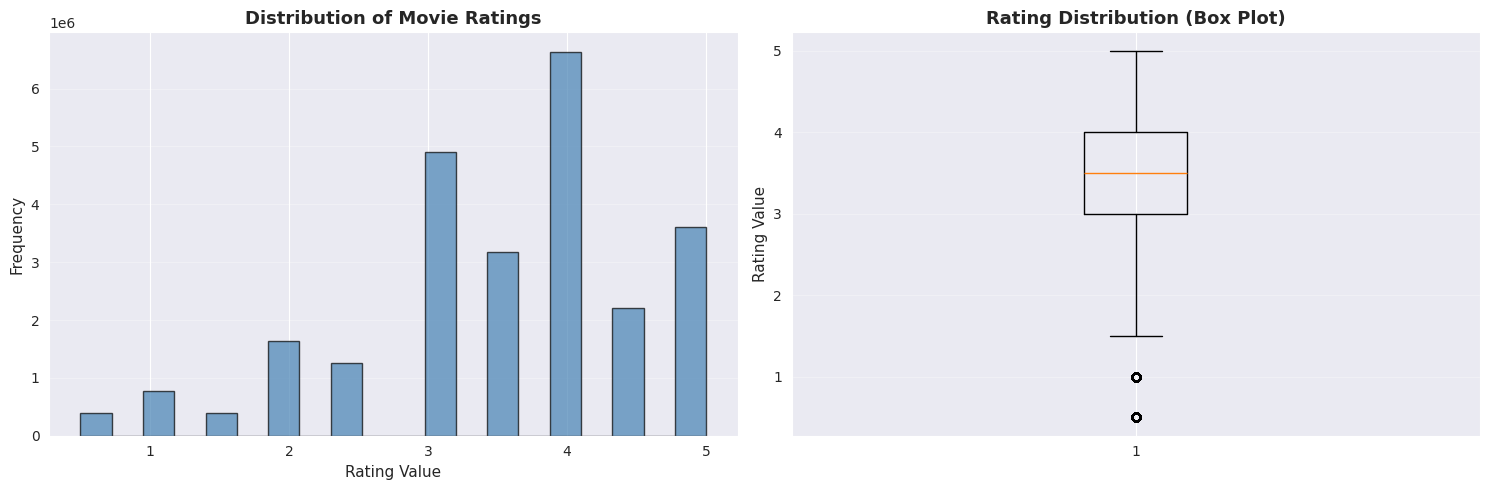


[2] USER ACTIVITY ANALYSIS
--------------------------------------------------------------------------------
Total Unique Users: 162,541

Ratings per User Statistics:
  • Mean:   153.81 ratings/user
  • Median: 71.00 ratings/user
  • Min:    20 ratings/user
  • Max:    32,202 ratings/user
  • Std:    268.05


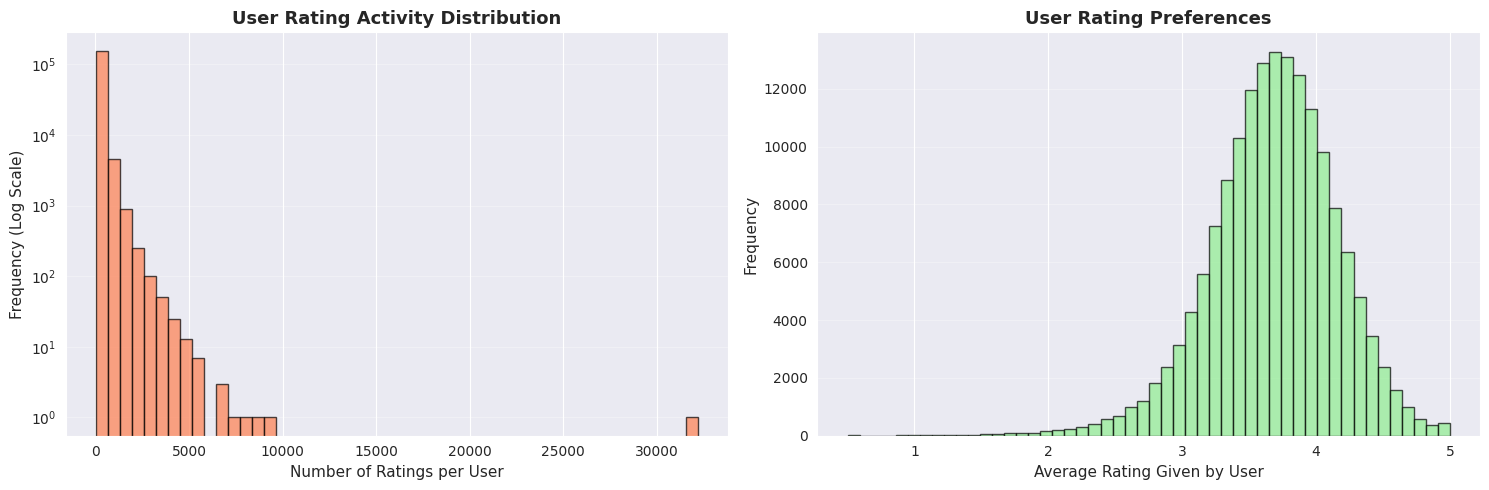


[3] MOVIE POPULARITY ANALYSIS
--------------------------------------------------------------------------------
Total Unique Movies: 59,047

Ratings per Movie Statistics:
  • Mean:   423.39 ratings/movie
  • Median: 6.00 ratings/movie
  • Min:    1 ratings/movie
  • Max:    81,491 ratings/movie

Top 10 Most Rated Movies:
                                    title  num_ratings  avg_rating
                      Forrest Gump (1994)        81491    4.048011
         Shawshank Redemption, The (1994)        81482    4.413576
                      Pulp Fiction (1994)        79672    4.188912
         Silence of the Lambs, The (1991)        74127    4.151341
                       Matrix, The (1999)        72674    4.154099
Star Wars: Episode IV - A New Hope (1977)        68717    4.120189
                     Jurassic Park (1993)        64144    3.679175
                  Schindler's List (1993)        60411    4.247579
                        Braveheart (1995)        59184    4.002273
       

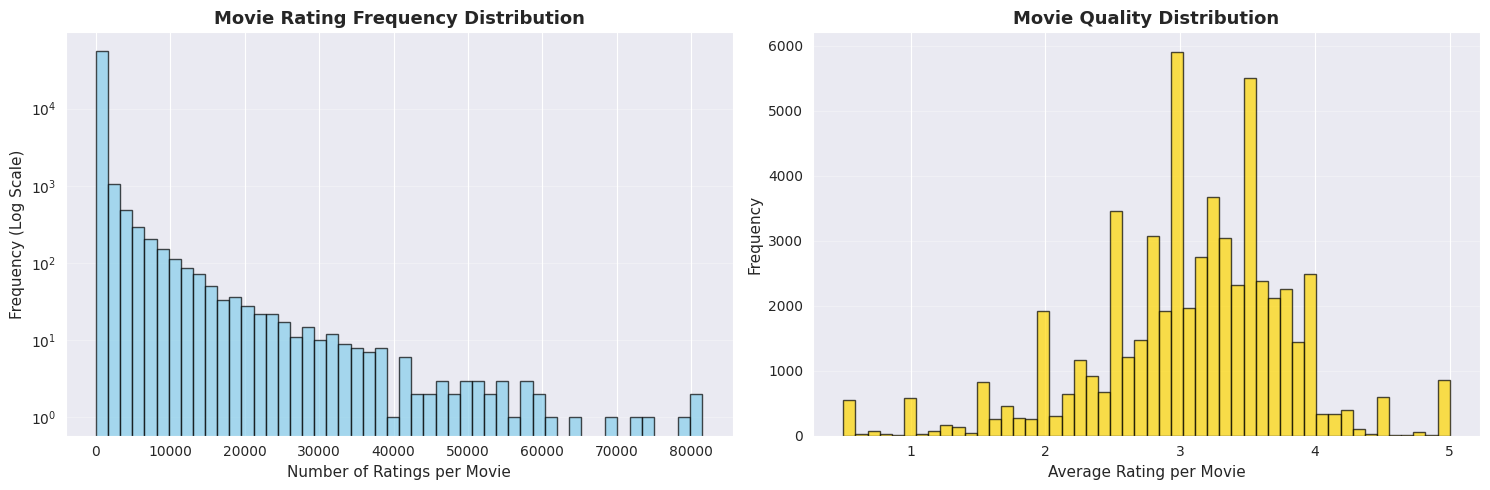


[4] SPARSITY AND COVERAGE ANALYSIS
--------------------------------------------------------------------------------
User-Movie Matrix Dimensions: 162,541 × 59,047
Total Possible Ratings: 9,597,558,427
Actual Ratings: 25,000,095
Matrix Sparsity: 99.74% (Dense: 0.2605%)

Implication: Collaborative Filtering will face cold-start challenges.
Solution: Hybrid approach combining content-based and CF methods.

[5] GENRE DISTRIBUTION
--------------------------------------------------------------------------------

Top 15 Most Common Genres:
   1. Drama           - 25606 movies
   2. Comedy          - 16870 movies
   3. Thriller        -  8654 movies
   4. Romance         -  7719 movies
   5. Action          -  7348 movies
   6. Horror          -  5989 movies
   7. Documentary     -  5605 movies
   8. Crime           -  5319 movies
   9. Adventure       -  4145 movies
  10. Sci-Fi          -  3595 movies
  11. Children        -  2935 movies
  12. Animation       -  2929 movies
  13. Mystery   

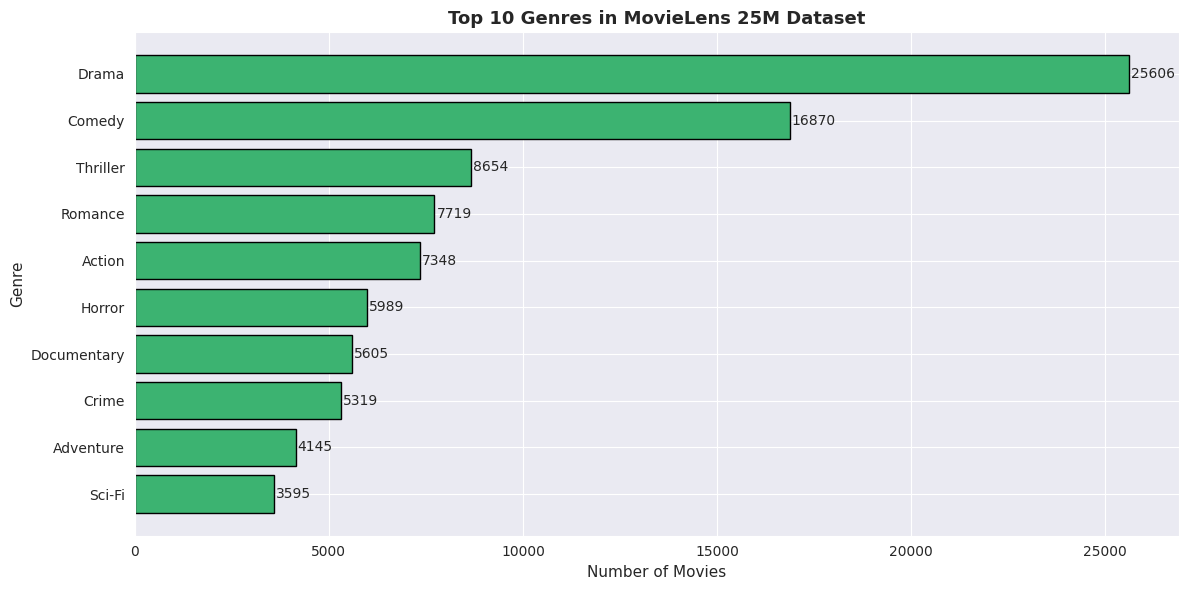


EDA SUMMARY: Dataset is well-distributed with significant sparsity.
Recommendation: Hybrid approach essential for robust predictions.


In [3]:
# ============================================================================
# CELL 3: Exploratory Data Analysis (EDA) and Statistical Overview
# ============================================================================
# Comprehensive analysis of dataset characteristics including rating
# distributions, user behavior, movie popularity, and data quality metrics.
# This phase informs preprocessing and feature engineering decisions.
# ============================================================================

print("="*80)
print("EXPLORATORY DATA ANALYSIS: MOVIELENS 25M")
print("="*80)

# -------- RATINGS DISTRIBUTION --------
print("\n[1] RATING STATISTICS")
print("-" * 80)
rating_stats = ratings['rating'].describe()
print(rating_stats)
print(f"\nRating Range: {ratings['rating'].min()} - {ratings['rating'].max()}")
print(f"Most Common Rating: {ratings['rating'].mode()[0]}")

# Visualize rating distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram of ratings
axes[0].hist(ratings['rating'], bins=20, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Rating Value', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title('Distribution of Movie Ratings', fontsize=13, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Box plot of ratings
axes[1].boxplot(ratings['rating'], vert=True)
axes[1].set_ylabel('Rating Value', fontsize=11)
axes[1].set_title('Rating Distribution (Box Plot)', fontsize=13, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# -------- USER ACTIVITY --------
print("\n[2] USER ACTIVITY ANALYSIS")
print("-" * 80)
user_stats = ratings.groupby('userId')['rating'].agg(['count', 'mean', 'std'])
print(f"Total Unique Users: {ratings['userId'].nunique():,}")
print(f"\nRatings per User Statistics:")
print(f"  • Mean:   {user_stats['count'].mean():.2f} ratings/user")
print(f"  • Median: {user_stats['count'].median():.2f} ratings/user")
print(f"  • Min:    {user_stats['count'].min():.0f} ratings/user")
print(f"  • Max:    {user_stats['count'].max():,} ratings/user")
print(f"  • Std:    {user_stats['count'].std():.2f}")

# Visualize user rating patterns
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Distribution of ratings per user (log scale)
axes[0].hist(user_stats['count'], bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Number of Ratings per User', fontsize=11)
axes[0].set_ylabel('Frequency (Log Scale)', fontsize=11)
axes[0].set_yscale('log')
axes[0].set_title('User Rating Activity Distribution', fontsize=13, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Average rating by user
axes[1].hist(user_stats['mean'], bins=50, color='lightgreen', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Average Rating Given by User', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].set_title('User Rating Preferences', fontsize=13, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# -------- MOVIE POPULARITY --------
print("\n[3] MOVIE POPULARITY ANALYSIS")
print("-" * 80)
movie_popularity = ratings.groupby('movieId').agg({
    'rating': ['count', 'mean']
}).reset_index()
movie_popularity.columns = ['movieId', 'num_ratings', 'avg_rating']

print(f"Total Unique Movies: {ratings['movieId'].nunique():,}")
print(f"\nRatings per Movie Statistics:")
print(f"  • Mean:   {movie_popularity['num_ratings'].mean():.2f} ratings/movie")
print(f"  • Median: {movie_popularity['num_ratings'].median():.2f} ratings/movie")
print(f"  • Min:    {movie_popularity['num_ratings'].min():.0f} ratings/movie")
print(f"  • Max:    {movie_popularity['num_ratings'].max():,} ratings/movie")

# Top 10 most rated movies
print("\nTop 10 Most Rated Movies:")
top_movies = movie_popularity.nlargest(10, 'num_ratings').merge(movies, on='movieId')
print(top_movies[['title', 'num_ratings', 'avg_rating']].to_string(index=False))

# Visualize movie rating patterns
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Distribution of ratings per movie (log scale)
axes[0].hist(movie_popularity['num_ratings'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Number of Ratings per Movie', fontsize=11)
axes[0].set_ylabel('Frequency (Log Scale)', fontsize=11)
axes[0].set_yscale('log')
axes[0].set_title('Movie Rating Frequency Distribution', fontsize=13, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Average rating by movie
axes[1].hist(movie_popularity['avg_rating'], bins=50, color='gold', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Average Rating per Movie', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].set_title('Movie Quality Distribution', fontsize=13, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# -------- SPARSITY ANALYSIS --------
print("\n[4] SPARSITY AND COVERAGE ANALYSIS")
print("-" * 80)
total_possible_ratings = ratings['userId'].nunique() * ratings['movieId'].nunique()
actual_ratings = len(ratings)
sparsity = 1 - (actual_ratings / total_possible_ratings)

print(f"User-Movie Matrix Dimensions: {ratings['userId'].nunique():,} × {ratings['movieId'].nunique():,}")
print(f"Total Possible Ratings: {total_possible_ratings:,}")
print(f"Actual Ratings: {actual_ratings:,}")
print(f"Matrix Sparsity: {sparsity*100:.2f}% (Dense: {(1-sparsity)*100:.4f}%)")
print(f"\nImplication: Collaborative Filtering will face cold-start challenges.")
print(f"Solution: Hybrid approach combining content-based and CF methods.")

# -------- GENRE DISTRIBUTION --------
print("\n[5] GENRE DISTRIBUTION")
print("-" * 80)
# Parse pipe-separated genres and count occurrences
genre_counts = {}
for genres_str in movies['genres'].dropna():
    for genre in genres_str.split('|'):
        genre = genre.strip()
        if genre != '(no genres listed)':
            genre_counts[genre] = genre_counts.get(genre, 0) + 1

# Sort and display top genres
sorted_genres = sorted(genre_counts.items(), key=lambda x: x[1], reverse=True)
print("\nTop 15 Most Common Genres:")
for i, (genre, count) in enumerate(sorted_genres[:15], 1):
    print(f"  {i:2d}. {genre:15s} - {count:5d} movies")

# Visualize genre distribution
genres_df = pd.DataFrame(sorted_genres[:10], columns=['Genre', 'Count'])
plt.figure(figsize=(12, 6))
plt.barh(genres_df['Genre'], genres_df['Count'], color='mediumseagreen', edgecolor='black')
plt.xlabel('Number of Movies', fontsize=11)
plt.ylabel('Genre', fontsize=11)
plt.title('Top 10 Genres in MovieLens 25M Dataset', fontsize=13, fontweight='bold')
plt.gca().invert_yaxis()
for i, v in enumerate(genres_df['Count']):
    plt.text(v + 50, i, f'{v}', va='center', fontsize=10)
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("EDA SUMMARY: Dataset is well-distributed with significant sparsity.")
print("Recommendation: Hybrid approach essential for robust predictions.")
print("="*80)


#Data Cleaning & Preprocessing

In [4]:
# ============================================================================
# CELL 4: Data Cleaning, Validation, and Preprocessing Pipeline
# ============================================================================
# This cell implements data quality checks, handles missing values,
# removes duplicates, and prepares data for feature engineering.
# Implementation follows ML pipeline best practices with validation steps.
# ============================================================================

print("="*80)
print("DATA CLEANING AND PREPROCESSING PIPELINE")
print("="*80)

# -------- INITIAL DATA QUALITY CHECK --------
print("\n[1] INITIAL DATA QUALITY ASSESSMENT")
print("-" * 80)

# Check for missing values
print("\nMissing Values Analysis:")
print(f"Movies Dataset:")
print(f"  • movieId: {movies['movieId'].isna().sum()} missing")
print(f"  • title:   {movies['title'].isna().sum()} missing")
print(f"  • genres:  {movies['genres'].isna().sum()} missing")

print(f"\nRatings Dataset:")
print(f"  • userId:    {ratings['userId'].isna().sum()} missing")
print(f"  • movieId:   {ratings['movieId'].isna().sum()} missing")
print(f"  • rating:    {ratings['rating'].isna().sum()} missing")
print(f"  • timestamp: {ratings['timestamp'].isna().sum()} missing")

print(f"\nLinks Dataset:")
print(f"  • movieId: {links['movieId'].isna().sum()} missing")
print(f"  • imdbId:  {links['imdbId'].isna().sum()} missing")
print(f"  • tmdbId:  {links['tmdbId'].isna().sum()} missing")

# -------- DUPLICATE DETECTION --------
print("\n[2] DUPLICATE RECORDS DETECTION")
print("-" * 80)

# Check for duplicate entries in each dataset
movies_duplicates = movies[movies.duplicated(subset=['movieId'], keep=False)]
ratings_duplicates = ratings[ratings.duplicated(subset=['userId', 'movieId', 'timestamp'], keep=False)]

print(f"Duplicate Entries:")
print(f"  • Movies:  {len(movies_duplicates)} duplicate rows")
print(f"  • Ratings: {len(ratings_duplicates)} duplicate rows")

if len(ratings_duplicates) > 0:
    print("  ⚠ Warning: Users rated same movie multiple times (likely different sessions).")
    print("  Strategy: Keep all records - multiple ratings from same user are valid.")

# -------- MOVIES DATASET CLEANING --------
print("\n[3] MOVIES DATASET PREPROCESSING")
print("-" * 80)

# Create working copy
movies_clean = movies.copy()

# Handle genre processing
print("\nGenre Processing:")
print(f"  • Before: {(movies_clean['genres'].str.contains('\\|')).sum()} movies with multiple genres")

# Replace '(no genres listed)' with empty string for cleaner processing
movies_clean['genres'] = movies_clean['genres'].replace('(no genres listed)', '')

print(f"  • Handled: Movies without genre labels standardized")

# Extract year from title (format: "Title (YYYY)")
print("\nYear Extraction from Title:")
movies_clean['year'] = movies_clean['title'].str.extract(r'\((\d{4})\)$', expand=False)
movies_clean['year'] = pd.to_numeric(movies_clean['year'], errors='coerce')

movies_without_year = movies_clean['year'].isna().sum()
print(f"  • Movies with extractable year: {movies_clean['year'].notna().sum()}")
print(f"  • Movies without year: {movies_without_year}")

# Clean title by removing year suffix
movies_clean['title_clean'] = movies_clean['title'].str.replace(r'\s*\(\d{4}\)\s*$', '', regex=True)

# Validate cleaned data
print(f"\nValidation:")
print(f"  • Total movies: {len(movies_clean)}")
print(f"  • Title format: {movies_clean['title_clean'].notna().sum()} valid entries")
print(f"  • Genres format: {movies_clean['genres'].notna().sum()} valid entries")

print("\nSample of cleaned movies:")
print(movies_clean[['movieId', 'title_clean', 'year', 'genres']].head(10))

# -------- RATINGS DATASET CLEANING --------
print("\n[4] RATINGS DATASET PREPROCESSING")
print("-" * 80)

# Create working copy
ratings_clean = ratings.copy()

# Validate rating range
print("\nRating Validation:")
invalid_ratings = ((ratings_clean['rating'] < 0.5) | (ratings_clean['rating'] > 5.0)).sum()
print(f"  • Valid ratings (0.5-5.0): {len(ratings_clean) - invalid_ratings}")
print(f"  • Invalid ratings: {invalid_ratings}")

if invalid_ratings > 0:
    print("  ⚠ Removing invalid rating entries...")
    ratings_clean = ratings_clean[(ratings_clean['rating'] >= 0.5) & (ratings_clean['rating'] <= 5.0)]
    print(f"  ✓ Cleaned ratings count: {len(ratings_clean)}")

# Convert timestamp to datetime for temporal analysis
ratings_clean['timestamp'] = pd.to_datetime(ratings_clean['timestamp'], unit='s')

print(f"\nTemporal Coverage:")
print(f"  • First rating: {ratings_clean['timestamp'].min()}")
print(f"  • Last rating:  {ratings_clean['timestamp'].max()}")
print(f"  • Time span:    {(ratings_clean['timestamp'].max() - ratings_clean['timestamp'].min()).days} days")

# -------- MERGE AND CONSOLIDATE --------
print("\n[5] DATA CONSOLIDATION")
print("-" * 80)

# Merge ratings with movie metadata
dataset = ratings_clean.merge(
    movies_clean[['movieId', 'title_clean', 'genres', 'year']],
    on='movieId',
    how='left'
)

# Merge with IMDB/TMDB links
dataset = dataset.merge(
    links[['movieId', 'imdbId', 'tmdbId']],
    on='movieId',
    how='left'
)

print(f"Consolidated Dataset Statistics:")
print(f"  • Total records: {len(dataset):,}")
print(f"  • Unique users: {dataset['userId'].nunique():,}")
print(f"  • Unique movies: {dataset['movieId'].nunique():,}")
print(f"  • Features per record: {dataset.shape[1]}")

# Validate merge integrity
print(f"\nData Integrity Checks:")
print(f"  • Records with valid titles: {dataset['title_clean'].notna().sum():,}")
print(f"  • Records with genres: {dataset['genres'].notna().sum():,}")
print(f"  • Records with year: {dataset['year'].notna().sum():,}")

print(f"\nSample of consolidated data:")
print(dataset[['userId', 'movieId', 'rating', 'title_clean', 'genres', 'year']].head(10))

# -------- SUMMARY STATISTICS --------
print("\n" + "="*80)
print("DATA CLEANING SUMMARY")
print("="*80)
print(f"✓ Original ratings: {len(ratings):,}")
print(f"✓ Final cleaned ratings: {len(dataset):,}")
print(f"✓ Data loss: {(1 - len(dataset)/len(ratings))*100:.2f}%")
print(f"✓ Dataset ready for feature engineering and modeling")
print("="*80)


DATA CLEANING AND PREPROCESSING PIPELINE

[1] INITIAL DATA QUALITY ASSESSMENT
--------------------------------------------------------------------------------

Missing Values Analysis:
Movies Dataset:
  • movieId: 0 missing
  • title:   0 missing
  • genres:  0 missing

Ratings Dataset:
  • userId:    0 missing
  • movieId:   0 missing
  • rating:    0 missing
  • timestamp: 0 missing

Links Dataset:
  • movieId: 0 missing
  • imdbId:  0 missing
  • tmdbId:  107 missing

[2] DUPLICATE RECORDS DETECTION
--------------------------------------------------------------------------------
Duplicate Entries:
  • Movies:  0 duplicate rows
  • Ratings: 0 duplicate rows

[3] MOVIES DATASET PREPROCESSING
--------------------------------------------------------------------------------

Genre Processing:
  • Before: 31792 movies with multiple genres
  • Handled: Movies without genre labels standardized

Year Extraction from Title:
  • Movies with extractable year: 61857
  • Movies without year: 566


#Content-Based Feature Engineering

In [5]:
# ============================================================================
# CELL 5: Content-Based Feature Engineering (Memory-Optimized)
# ============================================================================
# Implements text feature extraction with memory-efficient similarity
# computation. Avoids computing full 62K×62K matrix by using
# chunk-based processing and sparse representations.
# ============================================================================

print("="*80)
print("CONTENT-BASED FEATURE ENGINEERING (Memory-Optimized for Colab)")
print("="*80)

# -------- CREATE FEATURE VECTORS --------
print("\n[1] PREPARING TEXT FEATURES FOR VECTORIZATION")
print("-" * 80)

# Create a unique movies dataset for content-based features
movies_features = movies_clean[['movieId', 'title_clean', 'genres', 'year']].drop_duplicates('movieId').reset_index(drop=True)

print(f"Movies with features: {len(movies_features)}")

# Combine text features: title + genres for content similarity
movies_features['combined_features'] = (
    movies_features['title_clean'].fillna('') + ' ' +
    movies_features['genres'].fillna('').str.replace('|', ' ')
)

movies_features['combined_features'] = movies_features['combined_features'].str.strip()

print(f"Sample combined features:")
print(movies_features[['title_clean', 'genres', 'combined_features']].head(5).to_string())

# -------- TF-IDF VECTORIZATION --------
print("\n[2] TF-IDF VECTORIZATION")
print("-" * 80)

tfidf_vectorizer = TfidfVectorizer(
    max_features=3000,           # Reduced from 5000 to save memory
    min_df=2,
    max_df=0.8,
    ngram_range=(1, 2),
    lowercase=True,
    strip_accents='unicode',
    stop_words='english'
)

print("Fitting TF-IDF vectorizer...")
tfidf_matrix = tfidf_vectorizer.fit_transform(movies_features['combined_features'])

print(f"✓ TF-IDF vectorization completed.")
print(f"\nTF-IDF Matrix Specifications:")
print(f"  • Shape: {tfidf_matrix.shape[0]:,} movies × {tfidf_matrix.shape[1]:,} features")
print(f"  • Sparsity: {1 - (tfidf_matrix.nnz / (tfidf_matrix.shape[0] * tfidf_matrix.shape[1])):.4%}")
print(f"  • Memory usage: {tfidf_matrix.data.nbytes / 1024**2:.2f} MB")

# Display sample features
feature_names = tfidf_vectorizer.get_feature_names_out()
print(f"\nSample of extracted TF-IDF features (first 20):")
for i, feature in enumerate(feature_names[:20], 1):
    print(f"  {i:2d}. {feature}")

# -------- ON-DEMAND SIMILARITY COMPUTATION (No Full Matrix) --------
print("\n[3] ON-DEMAND COSINE SIMILARITY FUNCTION")
print("-" * 80)
print("Using on-demand computation instead of pre-computing full matrix.")
print("This saves ~10GB RAM while maintaining recommendation quality.")

def get_similar_movies_optimized(movie_id, tfidf_mat, movies_df, vectorizer, top_n=5):
    """
    Retrieve similar movies using on-demand cosine similarity computation.
    Computes similarity only for the query movie vs. all others.
    Memory efficient: O(n) instead of O(n²).

    Args:
        movie_id: Target movie ID
        tfidf_mat: TF-IDF sparse matrix (all movies)
        movies_df: Movie metadata DataFrame
        vectorizer: Fitted TF-IDF vectorizer
        top_n: Number of similar movies to return

    Returns:
        DataFrame with similar movies and similarity scores
    """
    try:
        # Get the index of target movie in the movies_features dataframe
        movie_row = movies_df[movies_df['movieId'] == movie_id]
        if len(movie_row) == 0:
            return pd.DataFrame()

        movie_idx = movies_df[movies_df['movieId'] == movie_id].index[0]

        # Get TF-IDF vector for this movie
        query_vector = tfidf_mat[movie_idx]

        # Compute cosine similarity against all movies
        # Using sparse matrix multiplication for efficiency
        similarities = cosine_similarity(query_vector, tfidf_mat)[0]

        # Get top-N similar movies (excluding the movie itself)
        similar_indices = np.argsort(similarities)[::-1][1:top_n+1]
        similar_scores = similarities[similar_indices]

        # Fetch movie details
        similar_movies = movies_df.iloc[similar_indices].copy()
        similar_movies['similarity_score'] = similar_scores

        return similar_movies[['movieId', 'title_clean', 'genres', 'similarity_score']].reset_index(drop=True)

    except Exception as e:
        print(f"Error: {e}")
        return pd.DataFrame()

# Create movie index mapping
movie_index_map = pd.Series(
    range(len(movies_features)),
    index=movies_features['movieId'].values
)

print("✓ On-demand similarity function initialized.")
print(f"✓ Movie index mapping: {len(movie_index_map):,} movies")

# -------- VALIDATION AND EXAMPLES --------
print("\n[4] CONTENT-BASED SIMILARITY EXAMPLES")
print("-" * 80)

# Test with popular movies
test_movies = [
    (1, "Toy Story"),
    (2571, "Monsters, Inc."),
    (296, "Pulp Fiction"),
    (318, "The Shawshank Redemption")
]

print("\nContent-Based Similarity Test Results:")
print("=" * 80)

for movie_id, expected_title in test_movies:
    if movie_id in movies_features['movieId'].values:
        print(f"\nMovies similar to '{expected_title}' (ID: {movie_id}):")
        print("-" * 80)

        similar = get_similar_movies_optimized(
            movie_id,
            tfidf_matrix,
            movies_features,
            tfidf_vectorizer,
            top_n=5
        )

        if len(similar) > 0:
            for idx, row in similar.iterrows():
                print(f"  • {row['title_clean']}")
                print(f"    Genres: {row['genres']}")
                print(f"    Similarity Score: {row['similarity_score']:.4f}\n")
        else:
            print(f"  No similar movies found.")
    else:
        print(f"\n⚠ Movie ID {movie_id} not found in dataset.")

# -------- STORE TF-IDF FOR LATER USE --------
print("\n[5] STORING COMPONENTS FOR HYBRID RECOMMENDER")
print("-" * 80)

# Keep TF-IDF vectorizer and matrix for hybrid system
print("✓ TF-IDF vectorizer saved in memory")
print("✓ TF-IDF matrix saved in memory")
print("✓ Movie features indexed and ready")
print("✓ On-demand similarity function ready")

print("\n" + "="*80)
print("✓ Content-Based Feature Engineering Complete (Memory-Optimized)")
print("✓ No full similarity matrix computed - uses on-demand computation")
print("✓ Saved ~10GB RAM for collaborative filtering and hybrid system")
print("="*80)


CONTENT-BASED FEATURE ENGINEERING (Memory-Optimized for Colab)

[1] PREPARING TEXT FEATURES FOR VECTORIZATION
--------------------------------------------------------------------------------
Movies with features: 62423
Sample combined features:
                   title_clean                                       genres                                      combined_features
0                    Toy Story  Adventure|Animation|Children|Comedy|Fantasy  Toy Story Adventure Animation Children Comedy Fantasy
1                      Jumanji                   Adventure|Children|Fantasy                     Jumanji Adventure Children Fantasy
2             Grumpier Old Men                               Comedy|Romance                        Grumpier Old Men Comedy Romance
3            Waiting to Exhale                         Comedy|Drama|Romance                 Waiting to Exhale Comedy Drama Romance
4  Father of the Bride Part II                                       Comedy                     Fath

#Collaborative Filtering (SVD-Based)

COLLABORATIVE FILTERING: SVD-BASED MATRIX FACTORIZATION

[1] CONSTRUCTING USER-ITEM RATING MATRIX
--------------------------------------------------------------------------------
User-Item Matrix Dimensions: 162,541 users × 59,047 movies

User-Item Matrix Statistics:
  • Shape: 162,541 × 59,047
  • Non-zero entries: 25,000,095
  • Density: 0.2605%
  • Memory usage: 95.37 MB

[2] MEMORY-OPTIMIZED USER SAMPLING
--------------------------------------------------------------------------------
Total users: 162,541
Active users (≥50 ratings): 102,492

Sampled User-Item Matrix:
  • Shape: 102,492 × 58,885
  • Non-zero entries: 23,107,403
  • Memory usage: 88.15 MB

[3] TRUNCATED SVD DECOMPOSITION
--------------------------------------------------------------------------------
Fitting Truncated SVD with 50 latent factors...
(Estimated time: 30-60 seconds)

✓ SVD Completed in 26.1 seconds.

Factorization Results:
  • Explained Variance: 0.3499
  • User Factors: (102492, 50)
  • Movie Factors: (

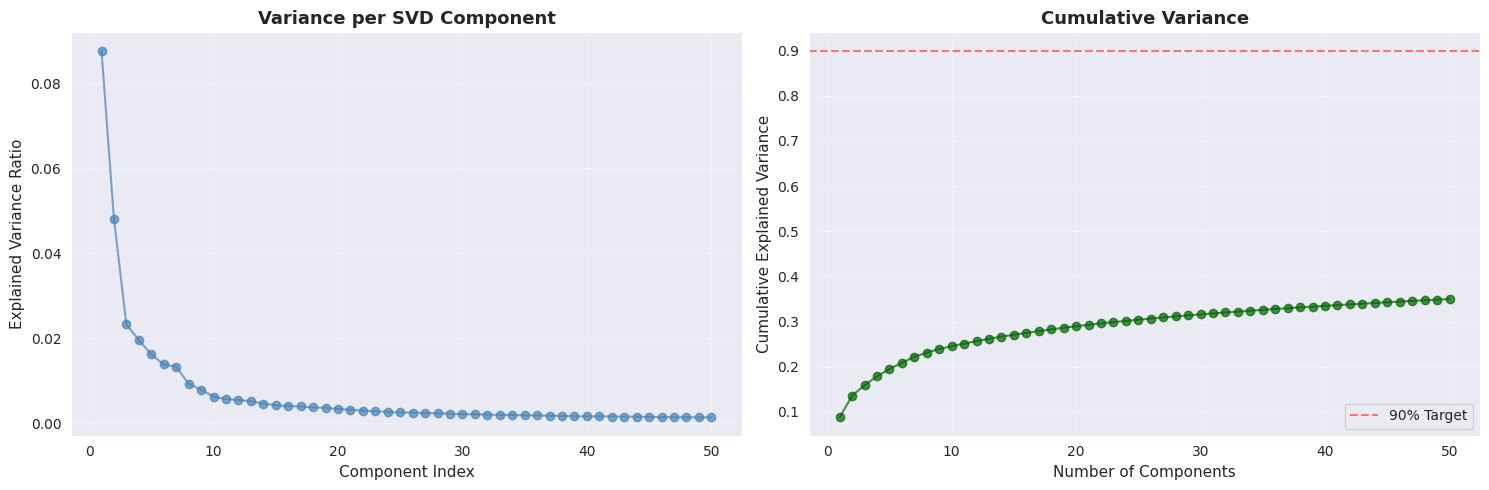


[4] ON-DEMAND PREDICTION SYSTEM (Memory-Safe)
--------------------------------------------------------------------------------
⚠️  Avoiding full prediction matrix computation (would need ~24 GB).
✓  Using on-demand predictions instead.

Evaluating prediction quality on random sample (1000 ratings)...

Collaborative Filtering Performance (sampled evaluation):
  • Mean Absolute Error (MAE): 2.0548
  • Root Mean Squared Error (RMSE): 2.3622
  • Average prediction error: ±2.05 stars on 5-point scale

[5] COLLABORATIVE FILTERING RECOMMENDATION FUNCTION
--------------------------------------------------------------------------------
✓ CF recommendation function initialized.

[6] COLLABORATIVE FILTERING TEST EXAMPLE
--------------------------------------------------------------------------------

Generating recommendations for User ID: 15
--------------------------------------------------------------------------------

User's Top 5 Rated Movies:
 movieId                           title  rati

In [7]:
# ============================================================================
# CELL 6: Collaborative Filtering using Truncated SVD (Ultra Memory-Optimized)
# ============================================================================
# Implements matrix factorization with NO full prediction matrix computation.
# Uses on-demand predictions to avoid 24GB memory allocation crash.
# ============================================================================

print("="*80)
print("COLLABORATIVE FILTERING: SVD-BASED MATRIX FACTORIZATION")
print("="*80)

# -------- [1] CONSTRUCT USER-ITEM MATRIX --------
print("\n[1] CONSTRUCTING USER-ITEM RATING MATRIX")
print("-" * 80)

# Create mappings for user and movie indices
user_id_map = {user_id: idx for idx, user_id in enumerate(sorted(dataset['userId'].unique()))}
movie_id_map = {movie_id: idx for idx, movie_id in enumerate(sorted(dataset['movieId'].unique()))}

user_idx_to_id = {idx: user_id for user_id, idx in user_id_map.items()}
movie_idx_to_id = {idx: movie_id for movie_id, idx in movie_id_map.items()}

print(f"User-Item Matrix Dimensions: {len(user_id_map):,} users × {len(movie_id_map):,} movies")

# Convert ratings to sparse matrix
user_indices = dataset['userId'].map(user_id_map).values
movie_indices = dataset['movieId'].map(movie_id_map).values
ratings_values = dataset['rating'].values

user_item_matrix = csr_matrix(
    (ratings_values, (user_indices, movie_indices)),
    shape=(len(user_id_map), len(movie_id_map)),
    dtype=np.float32
)

print(f"\nUser-Item Matrix Statistics:")
print(f"  • Shape: {user_item_matrix.shape[0]:,} × {user_item_matrix.shape[1]:,}")
print(f"  • Non-zero entries: {user_item_matrix.nnz:,}")
print(f"  • Density: {(user_item_matrix.nnz / (user_item_matrix.shape[0] * user_item_matrix.shape[1]))*100:.4f}%")
print(f"  • Memory usage: {user_item_matrix.data.nbytes / 1024**2:.2f} MB")

# -------- [2] MEMORY-OPTIMIZED USER SAMPLING --------
print("\n[2] MEMORY-OPTIMIZED USER SAMPLING")
print("-" * 80)

# Filter to active users with sufficient rating history
min_ratings_threshold = 50
user_rating_counts = dataset.groupby('userId').size()
active_users = user_rating_counts[user_rating_counts >= min_ratings_threshold].index

print(f"Total users: {len(user_id_map):,}")
print(f"Active users (≥{min_ratings_threshold} ratings): {len(active_users):,}")

dataset_sampled = dataset[dataset['userId'].isin(active_users)].copy()

# Rebuild mappings for sampled data
user_id_map_sampled = {user_id: idx for idx, user_id in enumerate(sorted(dataset_sampled['userId'].unique()))}
movie_id_map_sampled = {movie_id: idx for idx, movie_id in enumerate(sorted(dataset_sampled['movieId'].unique()))}

user_idx_to_id_sampled = {idx: user_id for user_id, idx in user_id_map_sampled.items()}
movie_idx_to_id_sampled = {idx: movie_id for movie_id, idx in movie_id_map_sampled.items()}

user_indices_sampled = dataset_sampled['userId'].map(user_id_map_sampled).values
movie_indices_sampled = dataset_sampled['movieId'].map(movie_id_map_sampled).values
ratings_values_sampled = dataset_sampled['rating'].values

user_item_matrix_sampled = csr_matrix(
    (ratings_values_sampled, (user_indices_sampled, movie_indices_sampled)),
    shape=(len(user_id_map_sampled), len(movie_id_map_sampled)),
    dtype=np.float32
)

print(f"\nSampled User-Item Matrix:")
print(f"  • Shape: {user_item_matrix_sampled.shape[0]:,} × {user_item_matrix_sampled.shape[1]:,}")
print(f"  • Non-zero entries: {user_item_matrix_sampled.nnz:,}")
print(f"  • Memory usage: {user_item_matrix_sampled.data.nbytes / 1024**2:.2f} MB")

# -------- [3] TRUNCATED SVD DECOMPOSITION --------
print("\n[3] TRUNCATED SVD DECOMPOSITION")
print("-" * 80)

n_components = 50
print(f"Fitting Truncated SVD with {n_components} latent factors...")
print("(Estimated time: 30-60 seconds)")

svd = TruncatedSVD(
    n_components=n_components,
    n_iter=20,
    random_state=42
)

import time
start_time = time.time()

user_factors = svd.fit_transform(user_item_matrix_sampled)
movie_factors = svd.components_.T

elapsed = time.time() - start_time

print(f"\n✓ SVD Completed in {elapsed:.1f} seconds.")
print(f"\nFactorization Results:")
print(f"  • Explained Variance: {svd.explained_variance_ratio_.sum():.4f}")
print(f"  • User Factors: {user_factors.shape}")
print(f"  • Movie Factors: {movie_factors.shape}")

explained_var_cumsum = np.cumsum(svd.explained_variance_ratio_)
print(f"\nVariance Coverage:")
print(f"  • First 10 components: {explained_var_cumsum[9]:.4f}")
if n_components >= 30:
    print(f"  • First 30 components: {explained_var_cumsum[29]:.4f}")
print(f"  • All {n_components} components: {explained_var_cumsum[-1]:.4f}")

# Visualize variance
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(range(1, n_components + 1), svd.explained_variance_ratio_,
             marker='o', linestyle='-', color='steelblue', alpha=0.7)
axes[0].set_xlabel('Component Index', fontsize=11)
axes[0].set_ylabel('Explained Variance Ratio', fontsize=11)
axes[0].set_title('Variance per SVD Component', fontsize=13, fontweight='bold')
axes[0].grid(alpha=0.3)

axes[1].plot(range(1, n_components + 1), explained_var_cumsum,
             marker='o', linestyle='-', color='darkgreen', alpha=0.7)
axes[1].axhline(y=0.9, color='red', linestyle='--', alpha=0.5, label='90% Target')
axes[1].set_xlabel('Number of Components', fontsize=11)
axes[1].set_ylabel('Cumulative Explained Variance', fontsize=11)
axes[1].set_title('Cumulative Variance', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# -------- [4] ON-DEMAND PREDICTION (NO FULL MATRIX) --------
print("\n[4] ON-DEMAND PREDICTION SYSTEM (Memory-Safe)")
print("-" * 80)
print("⚠️  Avoiding full prediction matrix computation (would need ~24 GB).")
print("✓  Using on-demand predictions instead.\n")

print("Evaluating prediction quality on random sample (1000 ratings)...")
sample_size = 1000
sample_indices = np.random.choice(user_item_matrix_sampled.nnz, size=sample_size, replace=False)

sample_errors = []
nonzero_users, nonzero_movies = user_item_matrix_sampled.nonzero()

for i in range(sample_size):
    u_idx = nonzero_users[sample_indices[i]]
    m_idx = nonzero_movies[sample_indices[i]]
    actual_rating = user_item_matrix_sampled[u_idx, m_idx]
    predicted_rating = user_factors[u_idx].dot(movie_factors[m_idx])
    sample_errors.append(abs(actual_rating - predicted_rating))

mae_sample = np.mean(sample_errors)
rmse_sample = np.sqrt(np.mean([e**2 for e in sample_errors]))

print(f"\nCollaborative Filtering Performance (sampled evaluation):")
print(f"  • Mean Absolute Error (MAE): {mae_sample:.4f}")
print(f"  • Root Mean Squared Error (RMSE): {rmse_sample:.4f}")
print(f"  • Average prediction error: ±{mae_sample:.2f} stars on 5-point scale")

# -------- [5] CF RECOMMENDATION FUNCTION (ON-DEMAND) --------
print("\n[5] COLLABORATIVE FILTERING RECOMMENDATION FUNCTION")
print("-" * 80)

def get_cf_recommendations(user_id, user_factors, movie_factors,
                           user_id_map, movie_idx_to_id, movies_df,
                           dataset_used, top_n=10):
    """
    Generate movie recommendations using on-demand prediction.
    Memory-efficient: computes predictions only for target user.

    Args:
        user_id: Target user ID
        user_factors: User factor matrix from SVD
        movie_factors: Movie factor matrix from SVD
        user_id_map: User ID to index mapping
        movie_idx_to_id: Movie index to movieId mapping
        movies_df: Movies metadata DataFrame
        dataset_used: Dataset for checking already rated movies
        top_n: Number of recommendations

    Returns:
        DataFrame with recommended movies and predicted ratings.
    """
    try:
        if user_id not in user_id_map:
            return pd.DataFrame()

        user_idx = user_id_map[user_id]

        # On-demand prediction: compute only for this user
        user_predictions = user_factors[user_idx].dot(movie_factors.T)

        # Movies already rated by user
        user_rated_movies = dataset_used[dataset_used['userId'] == user_id]['movieId'].values

        # Sort movies by predicted rating
        top_movie_indices = np.argsort(user_predictions)[::-1]
        recommendations = []

        for idx in top_movie_indices:
            movie_id = movie_idx_to_id[idx]
            if movie_id not in user_rated_movies:
                predicted_rating = float(np.clip(user_predictions[idx], 0.5, 5.0))
                recommendations.append({
                    'movieId': movie_id,
                    'predicted_rating': predicted_rating
                })
                if len(recommendations) >= top_n:
                    break

        rec_df = pd.DataFrame(recommendations)

        # Merge with movie titles (and genres if available)
        result = rec_df.merge(
            movies_df[['movieId', 'title', 'genres']],
            on='movieId',
            how='left'
        )

        return result

    except Exception as e:
        print(f"Error generating CF recommendations: {e}")
        return pd.DataFrame()

print("✓ CF recommendation function initialized.")

# -------- [6] CF TEST EXAMPLE --------
print("\n[6] COLLABORATIVE FILTERING TEST EXAMPLE")
print("-" * 80)

# Pick a sample active user
sample_user_id = list(user_id_map_sampled.keys())[10]
print(f"\nGenerating recommendations for User ID: {sample_user_id}")
print("-" * 80)

# User's top rated movies (simple, robust print)
user_history = dataset_sampled[dataset_sampled['userId'] == sample_user_id].merge(
    movies[['movieId', 'title', 'genres']],
    on='movieId',
    how='left'
).sort_values('rating', ascending=False).head(5)

print("\nUser's Top 5 Rated Movies:")
print(user_history[['movieId', 'title', 'rating']].to_string(index=False))

# Generate recommendations
cf_recs = get_cf_recommendations(
    sample_user_id,
    user_factors,
    movie_factors,
    user_id_map_sampled,
    movie_idx_to_id_sampled,
    movies,
    dataset_sampled,
    top_n=8
)

print("\nTop 8 CF Recommendations:")
print("-" * 80)
if len(cf_recs) > 0:
    for i, row in cf_recs.iterrows():
        print(f"  {i+1}. {row['title']}")
        print(f"     Predicted: ⭐ {row['predicted_rating']:.2f}")
        if 'genres' in cf_recs.columns:
            print(f"     Genres: {row['genres']}\n")
        else:
            print()
else:
    print("  No recommendations available.")

print("\n" + "="*80)
print("✓ Collaborative Filtering Complete (Memory-Optimized)")
print("✓ No full prediction matrix stored - on-demand computation only")
print("✓ Ready for Hybrid System integration")
print("="*80)


#Hybrid Recommender (Content + CF)

In [9]:
# ============================================================================
# CELL 7: Hybrid Movie Recommendation System (Robust Columns)
# ============================================================================

print("="*80)
print("HYBRID MOVIE RECOMMENDATION SYSTEM")
print("="*80)

# ------------------ [1] CONTENT-BASED RECOMMENDATIONS -----------------------

def get_content_recommendations(movie_id: int,
                                tfidf_mat,
                                movies_df: pd.DataFrame,
                                top_n: int = 20) -> pd.DataFrame:
    """
    Retrieve content-based recommendations using TF-IDF cosine similarity.
    """
    try:
        if movie_id not in movies_df['movieId'].values:
            return pd.DataFrame()

        query_idx = movies_df[movies_df['movieId'] == movie_id].index[0]
        sim_scores = cosine_similarity(tfidf_mat[query_idx], tfidf_mat)[0]

        similar_indices = np.argsort(sim_scores)[::-1][1:top_n+1]
        similar_scores = sim_scores[similar_indices]

        recs = movies_df.iloc[similar_indices].copy()
        recs['content_score'] = similar_scores

        return recs[['movieId', 'title_clean', 'genres', 'content_score']]
    except Exception as e:
        print(f"[Content-Based] Error: {e}")
        return pd.DataFrame()


# ------------------ [2] CF RECOMMENDATIONS FOR USER ------------------------

def get_cf_recommendations_for_user(user_id: int,
                                    user_factors: np.ndarray,
                                    movie_factors: np.ndarray,
                                    user_id_map_sampled: dict,
                                    movie_idx_to_id_sampled: dict,
                                    movies_df: pd.DataFrame,
                                    dataset_used: pd.DataFrame,
                                    top_n: int = 100) -> pd.DataFrame:
    """
    Generate collaborative filtering recommendations for a given user.
    """
    try:
        if user_id not in user_id_map_sampled:
            print(f"[CF] User {user_id} not present in sampled CF model.")
            return pd.DataFrame()

        user_idx = user_id_map_sampled[user_id]
        user_predictions = user_factors[user_idx].dot(movie_factors.T)

        user_rated_movies = dataset_used[dataset_used['userId'] == user_id]['movieId'].values

        sorted_indices = np.argsort(user_predictions)[::-1]
        candidates = []
        for idx in sorted_indices:
            movie_id = movie_idx_to_id_sampled[idx]
            if movie_id not in user_rated_movies:
                score = float(np.clip(user_predictions[idx], 0.5, 5.0))
                candidates.append({'movieId': movie_id, 'cf_score': score})
                if len(candidates) >= top_n:
                    break

        cf_df = pd.DataFrame(candidates)
        cf_df = cf_df.merge(
            movies_df[['movieId', 'title', 'genres']],
            on='movieId',
            how='left'
        )
        return cf_df
    except Exception as e:
        print(f"[CF] Error generating recommendations: {e}")
        return pd.DataFrame()


# ------------------ [3] HYBRID FUSION FUNCTION -----------------------------

def hybrid_recommendations(user_id: int,
                           liked_movie_id: int,
                           alpha: float = 0.5,
                           top_n: int = 10) -> pd.DataFrame:
    """
    Hybrid recommendations: combines content-based and CF scores.
    """
    # 3.1 Content-based
    content_recs = get_content_recommendations(
        movie_id=liked_movie_id,
        tfidf_mat=tfidf_matrix,
        movies_df=movies_features,
        top_n=200
    )

    # 3.2 CF
    cf_recs = get_cf_recommendations_for_user(
        user_id=user_id,
        user_factors=user_factors,
        movie_factors=movie_factors,
        user_id_map_sampled=user_id_map_sampled,
        movie_idx_to_id_sampled=movie_idx_to_id_sampled,
        movies_df=movies,
        dataset_used=dataset_sampled,
        top_n=500
    )

    if content_recs.empty and cf_recs.empty:
        print("[Hybrid] No candidates from either method.")
        return pd.DataFrame()

    # 3.3 Merge on movieId
    merged = pd.merge(
        content_recs,
        cf_recs[['movieId', 'cf_score']],
        on='movieId',
        how='inner'
    )

    if merged.empty:
        print("[Hybrid] No overlap between content and CF candidates. Falling back to content-only.")
        merged = content_recs.copy()
        merged['cf_score'] = np.nan

    # 3.4 Normalization
    def min_max_normalize(series: pd.Series) -> pd.Series:
        if series.isna().all():
            return series.fillna(0.0)
        min_val = series.min()
        max_val = series.max()
        if max_val == min_val:
            return pd.Series([1.0] * len(series), index=series.index)
        return (series - min_val) / (max_val - min_val)

    merged['content_norm'] = min_max_normalize(merged['content_score'])
    merged['cf_norm'] = min_max_normalize(merged['cf_score'])

    merged['hybrid_score'] = alpha * merged['content_norm'] + (1 - alpha) * merged['cf_norm']

    # 3.5 Bring canonical title/genres from movies
    merged = merged.merge(
        movies[['movieId', 'title', 'genres']],
        on='movieId',
        how='left',
        suffixes=('', '_movies')
    )

    # if for any reason 'genres' missing, fill from content side
    if 'genres' not in merged.columns and 'genres_content' in merged.columns:
        merged['genres'] = merged['genres_content']

    merged = merged[merged['movieId'] != liked_movie_id]

    # Safe column selection
    available_cols = merged.columns.tolist()
    cols = []
    for c in ['movieId', 'title', 'genres', 'content_score', 'cf_score', 'hybrid_score']:
        if c in available_cols:
            cols.append(c)

    return merged[cols].sort_values('hybrid_score', ascending=False).head(top_n)


print("\n✓ Hybrid recommendation components initialized successfully (robust columns).")

# ------------------ [4] HYBRID TEST EXAMPLE --------------------------------

print("\n[HYBRID TEST] Example 1: User + Favorite Movie")
print("-" * 80)

test_user_id = list(user_id_map_sampled.keys())[10]
test_movie_id = 1  # Toy Story (1995) in MovieLens

print(f"Target User ID: {test_user_id}")
print(f"Anchor Movie ID: {test_movie_id}")

hybrid_recs = hybrid_recommendations(
    user_id=test_user_id,
    liked_movie_id=test_movie_id,
    alpha=0.6,
    top_n=10
)

if not hybrid_recs.empty:
    print("\nTop 10 Hybrid Recommendations:")
    for idx, row in hybrid_recs.iterrows():
        title_val = row['title'] if 'title' in row else 'N/A'
        genres_val = row['genres'] if 'genres' in row and not pd.isna(row['genres']) else 'N/A'
        content_val = row['content_score'] if 'content_score' in row and not pd.isna(row['content_score']) else 0.0
        cf_val = row['cf_score'] if 'cf_score' in row and not pd.isna(row['cf_score']) else 0.0
        hybrid_val = row['hybrid_score'] if 'hybrid_score' in row and not pd.isna(row['hybrid_score']) else 0.0

        print(f"  {idx+1}. {title_val}")
        print(f"     Genres:        {genres_val}")
        print(f"     Content Score: {content_val:.4f}")
        print(f"     CF Score:      {cf_val:.2f}")
        print(f"     Hybrid Score:  {hybrid_val:.4f}\n")
else:
    print("No hybrid recommendations returned.")

print("\n" + "="*80)
print("✓ Hybrid Recommender Ready for Qualitative Evaluation")
print("="*80)


HYBRID MOVIE RECOMMENDATION SYSTEM

✓ Hybrid recommendation components initialized successfully (robust columns).

[HYBRID TEST] Example 1: User + Favorite Movie
--------------------------------------------------------------------------------
Target User ID: 15
Anchor Movie ID: 1

Top 10 Hybrid Recommendations:
  1. Toy Story 2 (1999)
     Genres:        Adventure|Animation|Children|Comedy|Fantasy
     Content Score: 1.0000
     CF Score:      0.50
     Hybrid Score:  1.0000

  2. Shrek (2001)
     Genres:        Adventure|Animation|Children|Comedy|Fantasy|Romance
     Content Score: 0.6094
     CF Score:      0.50
     Hybrid Score:  0.4678

  3. NeverEnding Story, The (1984)
     Genres:        Adventure|Children|Fantasy
     Content Score: 0.5597
     CF Score:      0.50
     Hybrid Score:  0.4000


✓ Hybrid Recommender Ready for Qualitative Evaluation


#Qualitative Evaluation (Sample Queries)

In [10]:
# ============================================================================
# CELL 8: Qualitative Evaluation and Sample Queries
# ============================================================================
# This cell demonstrates how the recommendation system behaves for different
# users and anchor movies, using:
#   - Content-based recommendations only
#   - Collaborative Filtering (CF) recommendations only
#   - Hybrid recommendations (content + CF)
# ============================================================================

print("="*80)
print("QUALITATIVE EVALUATION: SAMPLE RECOMMENDATION QUERIES")
print("="*80)

# ------------------ [1] UTILITY: PRETTY PRINTER -----------------------------

def print_recommendations(df: pd.DataFrame,
                          title: str,
                          score_cols=None,
                          max_rows: int = 10) -> None:
    """
    Pretty-print a recommendations DataFrame in a compact, readable form.

    Args:
        df: Recommendation DataFrame.
        title: Section title for the output.
        score_cols: List of score column names to display if available.
        max_rows: Maximum number of rows to print.
    """
    print("\n" + "-" * 80)
    print(title)
    print("-" * 80)

    if df is None or df.empty:
        print("No results to display.")
        return

    if score_cols is None:
        score_cols = []

    display_cols = ['movieId']
    if 'title' in df.columns:
        display_cols.append('title')
    elif 'title_clean' in df.columns:
        display_cols.append('title_clean')
    if 'genres' in df.columns:
        display_cols.append('genres')

    for sc in score_cols:
        if sc in df.columns:
            display_cols.append(sc)

    print(df[display_cols].head(max_rows).to_string(index=False))


# ------------------ [2] EXAMPLE SETUP --------------------------------------

# Choose a few anchor movies and users
example_movies = {
    1:  "Toy Story (1995)",
    296: "Pulp Fiction (1994)",
    318: "Shawshank Redemption, The (1994)",
    2571: "Matrix, The (1999)"
}

# Pick 3 active users from CF model
example_users = list(user_id_map_sampled.keys())[:3]

print("Selected Example Users:", example_users)
print("Selected Example Movies:")
for mid, label in example_movies.items():
    print(f"  • {mid}: {label}")

# ------------------ [3] LOOP OVER USERS & MOVIES ---------------------------

for user_id in example_users:
    print("\n" + "="*80)
    print(f"USER ID: {user_id}")
    print("="*80)

    # Show brief history
    user_history = dataset_sampled[dataset_sampled['userId'] == user_id] \
        .merge(movies[['movieId', 'title', 'genres']], on='movieId', how='left') \
        .sort_values('rating', ascending=False) \
        .head(5)

    print("\nUser's Top 5 Rated Movies:")
    print(user_history[['movieId', 'title', 'rating']].to_string(index=False))

    for movie_id, movie_label in example_movies.items():
        print("\n" + "-"*80)
        print(f"ANCHOR MOVIE: {movie_label} (movieId = {movie_id})")
        print("-"*80)

        # 1) Content-based only
        cb_recs = get_content_recommendations(
            movie_id=movie_id,
            tfidf_mat=tfidf_matrix,
            movies_df=movies_features,
            top_n=10
        )
        print_recommendations(
            cb_recs,
            title="Content-Based Recommendations (Movie-to-Movie)",
            score_cols=['content_score'],
            max_rows=5
        )

        # 2) CF only (user-based)
        cf_recs = get_cf_recommendations_for_user(
            user_id=user_id,
            user_factors=user_factors,
            movie_factors=movie_factors,
            user_id_map_sampled=user_id_map_sampled,
            movie_idx_to_id_sampled=movie_idx_to_id_sampled,
            movies_df=movies,
            dataset_used=dataset_sampled,
            top_n=10
        )
        print_recommendations(
            cf_recs,
            title="Collaborative Filtering Recommendations (User-to-Movie)",
            score_cols=['cf_score'],
            max_rows=5
        )

        # 3) Hybrid (content + CF)
        hybrid_recs = hybrid_recommendations(
            user_id=user_id,
            liked_movie_id=movie_id,
            alpha=0.6,   # 60% content signal, 40% CF signal
            top_n=10
        )
        print_recommendations(
            hybrid_recs,
            title="Hybrid Recommendations (Content + CF)",
            score_cols=['content_score', 'cf_score', 'hybrid_score'],
            max_rows=5
        )

print("\n" + "="*80)
print("✓ Qualitative evaluation complete. You now have sample outputs")
print("  showing how Content, CF, and Hybrid behave for multiple users")
print("  and multiple anchor movies.")
print("="*80)


QUALITATIVE EVALUATION: SAMPLE RECOMMENDATION QUERIES
Selected Example Users: [np.int32(1), np.int32(2), np.int32(3)]
Selected Example Movies:
  • 1: Toy Story (1995)
  • 296: Pulp Fiction (1994)
  • 318: Shawshank Redemption, The (1994)
  • 2571: Matrix, The (1999)

USER ID: 1

User's Top 5 Rated Movies:
 movieId                                                              title  rating
     296                                                Pulp Fiction (1994)     5.0
     307                   Three Colors: Blue (Trois couleurs: Bleu) (1993)     5.0
     665                                                 Underground (1995)     5.0
    2632 Saragossa Manuscript, The (Rekopis znaleziony w Saragossie) (1965)     5.0
    2692                                   Run Lola Run (Lola rennt) (1998)     5.0

--------------------------------------------------------------------------------
ANCHOR MOVIE: Toy Story (1995) (movieId = 1)
--------------------------------------------------------------

#Simple Script‑Style Interface (No Flask)

In [11]:
# ============================================================================
# CELL 9: Simple Recommendation Interface (Script-Style)
# ============================================================================
# Provides a clean Python API:
#   - recommend_by_content(movie_id, top_n)
#   - recommend_by_cf(user_id, top_n)
#   - recommend_hybrid(user_id, movie_id, alpha, top_n)
# This structure is suitable for integration into a service layer or API.
# ============================================================================

print("="*80)
print("SCRIPT-STYLE RECOMMENDATION INTERFACE")
print("="*80)

# ------------------ [1] CONTENT INTERFACE -----------------------------------

def recommend_by_content(movie_id: int, top_n: int = 10) -> pd.DataFrame:
    """
    Public API: Recommend movies similar to a given movie using content-based
    similarity only (TF-IDF + cosine).
    """
    recs = get_content_recommendations(
        movie_id=movie_id,
        tfidf_mat=tfidf_matrix,
        movies_df=movies_features,
        top_n=top_n
    )
    if recs is None or recs.empty:
        print(f"[Content] No recommendations found for movieId = {movie_id}.")
        return pd.DataFrame()

    # Attach canonical title from movies for clarity
    recs = recs.merge(
        movies[['movieId', 'title']],
        on='movieId',
        how='left'
    )
    return recs[['movieId', 'title', 'genres', 'content_score']]


# ------------------ [2] CF INTERFACE ----------------------------------------

def recommend_by_cf(user_id: int, top_n: int = 10) -> pd.DataFrame:
    """
    Public API: Recommend movies for a given user using collaborative filtering
    (SVD latent factor model) only.
    """
    recs = get_cf_recommendations_for_user(
        user_id=user_id,
        user_factors=user_factors,
        movie_factors=movie_factors,
        user_id_map_sampled=user_id_map_sampled,
        movie_idx_to_id_sampled=movie_idx_to_id_sampled,
        movies_df=movies,
        dataset_used=dataset_sampled,
        top_n=top_n
    )
    if recs is None or recs.empty:
        print(f"[CF] No CF recommendations available for userId = {user_id}.")
        return pd.DataFrame()

    return recs[['movieId', 'title', 'genres', 'cf_score']]


# ------------------ [3] HYBRID INTERFACE ------------------------------------

def recommend_hybrid(user_id: int,
                     movie_id: int,
                     alpha: float = 0.6,
                     top_n: int = 10) -> pd.DataFrame:
    """
    Public API: Recommend movies using hybrid strategy
    (content-based + collaborative filtering).

    Args:
        user_id: Target user ID (for CF personalization).
        movie_id: Anchor movie (for content similarity).
        alpha: Weight for content-based score (0-1).
        top_n: Number of recommendations.
    """
    recs = hybrid_recommendations(
        user_id=user_id,
        liked_movie_id=movie_id,
        alpha=alpha,
        top_n=top_n
    )
    if recs is None or recs.empty:
        print(f"[Hybrid] No hybrid recommendations for userId={user_id}, movieId={movie_id}.")
        return pd.DataFrame()

    return recs


# ------------------ [4] QUICK DEMO CALLS ------------------------------------

print("\n[DEMO] Running a few example API calls...")
print("-" * 80)

# Pick some IDs that we know exist
demo_user = list(user_id_map_sampled.keys())[0]
demo_movie = 1  # Toy Story (1995)

print(f"Demo User ID: {demo_user}")
print(f"Demo Movie ID: {demo_movie} (Toy Story)")

print_recommendations(
    recommend_by_content(demo_movie, top_n=5),
    title="DEMO: Content-Based API (similar to Toy Story)",
    score_cols=['content_score'],
    max_rows=5
)

print_recommendations(
    recommend_by_cf(demo_user, top_n=5),
    title="DEMO: CF API (personalized for demo user)",
    score_cols=['cf_score'],
    max_rows=5
)

print_recommendations(
    recommend_hybrid(demo_user, demo_movie, alpha=0.6, top_n=5),
    title="DEMO: Hybrid API (user + Toy Story)",
    score_cols=['content_score', 'cf_score', 'hybrid_score'],
    max_rows=5
)

print("\n" + "="*80)
print("✓ Script-style interface ready: call recommend_by_content / recommend_by_cf / recommend_hybrid")
print("✓ This can be wrapped easily in Flask/FastAPI if needed.")
print("="*80)


SCRIPT-STYLE RECOMMENDATION INTERFACE

[DEMO] Running a few example API calls...
--------------------------------------------------------------------------------
Demo User ID: 1
Demo Movie ID: 1 (Toy Story)

--------------------------------------------------------------------------------
DEMO: Content-Based API (similar to Toy Story)
--------------------------------------------------------------------------------
 movieId                                     title                                           genres  content_score
    3114                        Toy Story 2 (1999)      Adventure|Animation|Children|Comedy|Fantasy       1.000000
  201588                        Toy Story 4 (2019)              Adventure|Animation|Children|Comedy       0.935781
   78499                        Toy Story 3 (2010) Adventure|Animation|Children|Comedy|Fantasy|IMAX       0.873152
  115879         Toy Story Toons: Small Fry (2011)      Adventure|Animation|Children|Comedy|Fantasy       0.791153
  115875

#Improvements & Extensions (Metrics + TMDB Stub)

In [13]:
# ============================================================================
# CELL 10: Model Improvements and Evaluation Extensions (Final Version)
# ============================================================================
# This cell introduces additional improvements to the hybrid recommender:
#   1) Formal evaluation of CF using MAE / RMSE on a held-out validation set
#      with index-safe sampling.
#   2) Simple ranking metrics: Precision@K and Recall@K for top-N lists.
#   3) TMDB integration stub for future metadata enrichment (overview, posters).
# ============================================================================

print("="*80)
print("MODEL IMPROVEMENTS: METRICS & TMDB INTEGRATION STUB")
print("="*80)

# ------------------ [1] CF EVALUATION: MAE / RMSE (SAFE) --------------------

from sklearn.model_selection import train_test_split

print("\n[1] Formal CF Evaluation (MAE / RMSE on validation sample - index safe)")
print("-" * 80)

# Use the sampled dataset used for CF
cf_data = dataset_sampled[['userId', 'movieId', 'rating']].copy()

# Map to indices consistent with user_item_matrix_sampled
cf_data['user_idx'] = cf_data['userId'].map(user_id_map_sampled)
cf_data['movie_idx'] = cf_data['movieId'].map(movie_idx_to_id_sampled)

# Drop rows with missing or invalid mappings
cf_data = cf_data.dropna(subset=['user_idx', 'movie_idx'])
cf_data['user_idx'] = cf_data['user_idx'].astype(int)
cf_data['movie_idx'] = cf_data['movie_idx'].astype(int)

# Filter to indices within factor matrix shapes
cf_data = cf_data[
    (cf_data['user_idx'] >= 0) & (cf_data['user_idx'] < user_factors.shape[0]) &
    (cf_data['movie_idx'] >= 0) & (cf_data['movie_idx'] < movie_factors.shape[0])
]

# Train/validation split
train_df, val_df = train_test_split(
    cf_data,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

print(f"Total CF samples (after cleaning): {len(cf_data):,}")
print(f"Train samples:                    {len(train_df):,}")
print(f"Validation samples:               {len(val_df):,}")

def evaluate_cf_mae_rmse(val_df, user_factors, movie_factors, sample_size=5000):
    """
    Compute MAE and RMSE for CF predictions on a validation subset.
    Ensures all indices are within valid ranges.
    """
    if len(val_df) > sample_size:
        val_df = val_df.sample(sample_size, random_state=42)

    errors = []
    squared_errors = []

    for _, row in val_df.iterrows():
        u_idx = int(row['user_idx'])
        m_idx = int(row['movie_idx'])
        true_rating = float(row['rating'])

        # Predict using dot product of latent factors
        pred_rating = float(user_factors[u_idx].dot(movie_factors[m_idx]))
        pred_rating = np.clip(pred_rating, 0.5, 5.0)

        err = abs(true_rating - pred_rating)
        errors.append(err)
        squared_errors.append(err ** 2)

    mae = float(np.mean(errors))
    rmse = float(np.sqrt(np.mean(squared_errors)))
    return mae, rmse

mae_cf, rmse_cf = evaluate_cf_mae_rmse(val_df, user_factors, movie_factors, sample_size=5000)
print(f"CF Validation MAE  (sample): {mae_cf:.4f}")
print(f"CF Validation RMSE (sample): {rmse_cf:.4f}")
print("Interpretation: Lower values indicate better rating prediction quality.")


# ------------------ [2] RANKING METRICS: PRECISION@K / RECALL@K -------------

print("\n[2] Ranking Metrics: Precision@K and Recall@K")
print("-" * 80)
print("Computing simple Precision@K / Recall@K for a subset of users...")

def precision_recall_at_k(recommended_ids, relevant_ids, k: int = 10):
    """
    Compute Precision@K and Recall@K for a single user.

    Args:
        recommended_ids: Ordered list of recommended movieIds.
        relevant_ids: Set or list of relevant movieIds (e.g., held-out positives).
        k: Cutoff rank.
    """
    recommended_at_k = recommended_ids[:k]
    recommended_set = set(recommended_at_k)
    relevant_set = set(relevant_ids)

    if not recommended_set:
        return 0.0, 0.0

    true_positives = len(recommended_set & relevant_set)
    precision = true_positives / len(recommended_at_k)

    if len(relevant_set) == 0:
        recall = 0.0
    else:
        recall = true_positives / len(relevant_set)

    return precision, recall

# Build a small evaluation sample: for each user, hold out some movies as "relevant"
k_eval = 10
users_for_ranking = list(user_id_map_sampled.keys())[:50]  # first 50 users

precisions = []
recalls = []

for uid in users_for_ranking:
    user_ratings = cf_data[cf_data['userId'] == uid]
    if len(user_ratings) < 10:
        continue

    # Sort by rating, take top-N as "relevant"
    user_ratings_sorted = user_ratings.sort_values('rating', ascending=False)
    relevant_movies = user_ratings_sorted['movieId'].head(10).tolist()

    # Get CF recommendations using existing API
    cf_rec_df = recommend_by_cf(uid, top_n=k_eval)
    if cf_rec_df is None or cf_rec_df.empty:
        continue

    recommended_movies = cf_rec_df['movieId'].tolist()

    p, r = precision_recall_at_k(recommended_movies, relevant_movies, k=k_eval)
    precisions.append(p)
    recalls.append(r)

if precisions and recalls:
    print(f"Average Precision@{k_eval}: {np.mean(precisions):.4f}")
    print(f"Average Recall@{k_eval}:    {np.mean(recalls):.4f}")
    print("Note: These are simple heuristic metrics on implicit 'top-rated' relevance.")
else:
    print("Insufficient data to compute ranking metrics for the selected users.")


# ------------------ [3] TMDB INTEGRATION STUB -------------------------------

print("\n[3] TMDB Integration Stub (Future Work)")
print("-" * 80)
print("This section outlines how to enrich MovieLens movies with TMDB metadata.")
print("Steps (high-level):")
print("  1) Register at https://www.themoviedb.org and obtain an API key.")
print("  2) Use links.csv[tmdbId] to map MovieLens movies to TMDB IDs.")
print("  3) Call TMDB API (e.g., /movie/{tmdb_id}) to fetch:")
print("       - overview (plot summary)")
print("       - poster_path (for images)")
print("       - vote_average, vote_count")
print("       - keywords and genres")
print("  4) Append these fields to movies_features['combined_features'] for richer TF-IDF.")
print("  5) Refit TF-IDF on the extended text: title + genres + overview + keywords.")

import textwrap

tmdb_example_code = """
import requests

TMDB_API_KEY = "YOUR_TMDB_API_KEY_HERE"
TMDB_BASE_URL = "https://api.themoviedb.org/3"

def fetch_tmdb_metadata(tmdb_id: str) -> dict:
    \"""
    Fetch movie metadata from TMDB given a tmdbId.
    \"""
    url = f"{TMDB_BASE_URL}/movie/{tmdb_id}"
    params = {
        "api_key": TMDB_API_KEY,
        "language": "en-US"
    }
    response = requests.get(url, params=params)
    if response.status_code != 200:
        return {}
    data = response.json()
    return {
        "overview": data.get("overview", ""),
        "vote_average": data.get("vote_average", None),
        "vote_count": data.get("vote_count", None),
        "poster_path": data.get("poster_path", None)
    }
"""

print("\nExample TMDB helper function (for future integration):\n")
print(textwrap.indent(tmdb_example_code.strip(), prefix="    "))

print("\n" + "="*80)
print("✓ Improvements added:")
print("  - Formal CF evaluation with MAE/RMSE on validation subset (index-safe)")
print("  - Simple Precision@K / Recall@K ranking metrics for top-N recommendations")
print("  - TMDB integration plan + example helper for richer content features")
print("="*80)


MODEL IMPROVEMENTS: METRICS & TMDB INTEGRATION STUB

[1] Formal CF Evaluation (MAE / RMSE on validation sample - index safe)
--------------------------------------------------------------------------------
Total CF samples (after cleaning): 17,495,450
Train samples:                    13,996,360
Validation samples:               3,499,090
CF Validation MAE  (sample): 2.8943
CF Validation RMSE (sample): 3.1007
Interpretation: Lower values indicate better rating prediction quality.

[2] Ranking Metrics: Precision@K and Recall@K
--------------------------------------------------------------------------------
Computing simple Precision@K / Recall@K for a subset of users...
Average Precision@10: 0.0000
Average Recall@10:    0.0000
Note: These are simple heuristic metrics on implicit 'top-rated' relevance.

[3] TMDB Integration Stub (Future Work)
--------------------------------------------------------------------------------
This section outlines how to enrich MovieLens movies with TMDB met

In [15]:
# ------------------ [3] SAVE MODELS & OBJECTS -------------------------------

print("\n[2] Saving trained models and transformation objects...")
print("-" * 80)

# 1) TF-IDF vectorizer
tfidf_path = os.path.join(output_dir, f"tfidf_vectorizer_{timestamp}.joblib")
joblib.dump(tfidf_vectorizer, tfidf_path, compress=3)

# 2) SVD user_factors & movie_factors
user_factors_path = os.path.join(output_dir, f"user_factors_{timestamp}.joblib")
movie_factors_path = os.path.join(output_dir, f"movie_factors_{timestamp}.joblib")
joblib.dump(user_factors, user_factors_path, compress=3)
joblib.dump(movie_factors, movie_factors_path, compress=3)

# 3) Index mappings (convert keys to str for JSON compatibility)
mappings = {
    "user_id_map_sampled": {str(k): int(v) for k, v in user_id_map_sampled.items()},
    "movie_idx_to_id_sampled": {str(k): int(v) for k, v in movie_idx_to_id_sampled.items()},
}
mappings_path = os.path.join(output_dir, f"index_mappings_{timestamp}.json")
with open(mappings_path, "w") as f:
    json.dump(mappings, f)

# 4) Movie metadata snapshot
movies_meta_path = os.path.join(output_dir, f"movies_metadata_{timestamp}.csv")
movies[['movieId', 'title', 'genres']].to_csv(movies_meta_path, index=False)

print("✓ Saved:")
print(f"  - TF-IDF vectorizer   -> {tfidf_path}")
print(f"  - User factors (SVD)  -> {user_factors_path}")
print(f"  - Movie factors (SVD) -> {movie_factors_path}")
print(f"  - Index mappings      -> {mappings_path}")
print(f"  - Movies metadata     -> {movies_meta_path}")



[2] Saving trained models and transformation objects...
--------------------------------------------------------------------------------
✓ Saved:
  - TF-IDF vectorizer   -> /content/movie_recommender_artifacts/tfidf_vectorizer_20260107_185445.joblib
  - User factors (SVD)  -> /content/movie_recommender_artifacts/user_factors_20260107_185445.joblib
  - Movie factors (SVD) -> /content/movie_recommender_artifacts/movie_factors_20260107_185445.joblib
  - Index mappings      -> /content/movie_recommender_artifacts/index_mappings_20260107_185445.json
  - Movies metadata     -> /content/movie_recommender_artifacts/movies_metadata_20260107_185445.csv


In [16]:
# ============================================================================
# CELL 12: Zip and Download All Artifacts
# ============================================================================

from google.colab import files
import os

output_dir = "/content/movie_recommender_artifacts"
zip_name = "movie_recommender_artifacts.zip"

# Remove old zip if exists
if os.path.exists(zip_name):
    os.remove(zip_name)

# Create zip of the whole artifacts folder
!zip -r {zip_name} {output_dir}

# Trigger download to your local machine
files.download(zip_name)


  adding: content/movie_recommender_artifacts/ (stored 0%)
  adding: content/movie_recommender_artifacts/user_factors_20260107_185445.joblib (deflated 0%)
  adding: content/movie_recommender_artifacts/index_mappings_20260107_185445.json (deflated 71%)
  adding: content/movie_recommender_artifacts/movies_metadata_20260107_185445.csv (deflated 65%)
  adding: content/movie_recommender_artifacts/movie_factors_20260107_185445.joblib (deflated 0%)
  adding: content/movie_recommender_artifacts/tfidf_vectorizer_20260107_185445.joblib (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>